# Graph Convolutional Policy Network for Goal-Directed Molecular Graph Generation
[github](https://github.com/bowenliu16/rl_graph_generation)

## Outline

크게 세 가지 아이디어를 합쳐놓은 형태이다.
1. Graph Representation - 분자의 그래프를 벡터형태로 나타내기 위한 방법
2. Reinforcement Learning - 전체 모델이 학습되는 방법
3. Adversarial Training - adversarial loss는 데이터셋으로부터 정의된 필요한 성질들에대한 보상(reward)으로 적용됨

### Graph Representation
Molecular Graph를 사용하였는데 이는 SMILES보다 더 고정적이기(robust) 때문이다. 예를 들어, 텍스트 기반인 SMILES는 분자 구조에서 원자 하나의 기호만 바뀌어도 분자 단위에서의 엄청난 구조 변화를 가져올 수 있다. 또한, SMILES에서는 partially generated text가 의미를 지니지 않는 경우가 많은 반면, partially generated molecular graph는 분자의 substructure로 해석 가능하다.

### Reinforcement Learning
강화 학습은 우리가 목적으로하는 분자의 생성에 적합한 학습 방법이다. 크게 두 가지의 도움되는 성질이 있다.
1. 강화학습은 drug likeness나 원자가와 같은 표현하기 힘든 조건들과 목표로 하는 성질들을 environment dynamics를 설정하고 보상함수를 설정해두는 것으로 보다 잘 다룰 수 있다.
2. 강화 학습은 다른  데이터셋에 있는 분자들을 새로 만들 수 있는 것뿐만 아니라 없던 분자들도 policy에 기반하여 만들 수 있게 된다.

### Adversarial Training
사전 지식(prior knowledge)을 포함시키는 것이 분자를 만드는 과정에서 중요하다. Adversarial training을 통해 학습을 시키면, generator로부터 만들어지는 분자를 discriminaotr가 실제의 분자와 구분하도록 학습되는데, 이 때 discriminator가 주어진 데이터셋의 정보들을 포함하고 있고 generator의 학습을 그 데이터셋의 정보대로 이끌어준다.

본 모델인 Graph Convolutional Policy Network(GCPN)에서는 기존의 molecular graph에 substructure이나 새로운 atom을 더하는 방식으로 새로운 분자를 만든다. 이 때 GCPN은 bond addition의 action을 예측하고 이것은 reward를 최대화하는 방향으로 학습된다. 즉, 분자를 만들 때 우리가 목표로 하는 성질을 가지면 reward가 최대화 되기 때문에 목표 성질을 가지는 분자를 만들게 될 것이다. Adversarial loss는 GCN으로 만들어지고, discriminator는 데이터셋의 예시분자들로 학습을 한다. 이런식으로 학습을 하면, adversarial loss를 통해 실제 분자와 거의 비슷한 분자가 만들어지고, RL을 통해 우리가 원하는 분자의 구조가 만들어진다.

논문에서는 크게 세 가지의 task를 수행하였다.
1. Molecule Property Optimization
2. Property Targeting
3. Conditional Property Optimization
ZINC dataset을 이용하였다. 

## Method
### Problem Definition
그래프는 (A, E, F)의 형태로 표현한다. A는 $n \times n$ 크기의 0과 1로 표현된 adjacency matrix이고, F는 $ n \times d$ 크기의 d개의 feature를 포함한 node feature이고, b개의 edge type이 존재할 때 E는 $b \times n \times n$ 크기의 0과 1로 표현된 edge-conditioned adjacency tensor이다. node $j, k$가 이어져 있을 때, $E_{i,j,k} = 1$이고 그 때 $A = \Sigma_{i=1}^b E_i$이다.(분자 결합의 종류는 하나로 결정되니 하나의 E가 1이면 나머지 E는 전부 0이 되기 때문에 A는 0이나 1로 표현 가능한 것 같다.) 가장 큰 목표는 $S(G)$라는 property function을 최대화 시키는 것이다.
두 가지의 prior knowledge가 제한 조건으로 작용한다.
1. 만들어진 그래프는 빡빡한 조건들을 모두 만족해야 한다.
2. 실제 그래프 $G$와 만들어진 그래프 $G'$을 distance metric $J(\cdot, \cdot)$로 비교하며 prior knowledge를 만들어둔다.
아래는 graph generation method의 전체적인 그림이다.

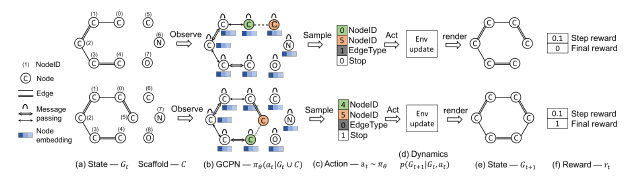

1. Scaffold subgraphs $C$가 GCPN 계산을 할 때 Intermediate graph $G_t$에 더해진다.
2. GCPN은 message passing을 통해 현재의 상태를 encode시키고 policy를 만들어낸다.
3. 4개의 성분을 가진 액션이 policy로부터 만들어진다.
4. 환경은 intermediate state의 화학적인 성질들을 체크한다.
5. 그 후, 다음 state인 $G_{t+1}$과 연관된 보상 $r_t$를 만든다.

### Graph Generation as Markov Decision Process
Decision Process는 모든 가능한 중간/최종 그래프의 상태를 포함하는 집합 $S$, 현재 그래프의 시간에 따른 변화를 표현한 action의 집합 $A$, action을 통해서 나올 수 있는 결과물의 집합 $P$, 그 다음 상태에 도달한 뒤의 보상에 대한 보상함수 $R(s_t)$, discount factor인 $\gamma$로 이루어진다. 이렇게 되면, 그래프를 만들기 위한 과정을 하나로 표현하면 $(s_0, a_0, r_0, \cdots, s_n, a_n, r_n)$으로 표현 가능하고, $s_n$이 최종적으로 생성된 그래프가 된다. 각 시간 순서에 따른 그래프의 변화는 state transition distribution으로 표현된다. 식으로 보면 $p(s_{t+1}|s_t, \cdot,  s_0) = \Sigma_{a_t} p(a_t|s_t, \cdot, s_0)p(s_{t+1}|s_t, \cdot, s_0, a_t)$처럼 표현되는데 이 때 $p(a_t|s_t, \cdot, s_0)$는 policy network $\pi_\theta$로 표현된다.
보통의 graph generation 과정은 RNN을 사용하여 각 step을 어느 정도 forget할 지에 대한 일종의 attention을 주면서 진행된다. 반면 이 논문에서는 Markov property인 $p(s_{t+1}|s_t, \cdot, s_0) = p(s_{t+1}|s|t)$를 만족하는 state transition dynamics가 필요한 Markov Decision Process를 사용한다. 이 성질을 가지고 있으면, policy network가 intermediate graph state $s_t$만을 액션을 유도하기 위해 필요로 한다. 이러한 액션은 환경을 통해 사용되며 intermediate graph를 업데이트 시킨다.

### Molecule Generation Environment
#### State Space
$s_t$는 time step $t$에서의 intermediate genearted graph $G_t$로 정의하였다. 강화 학습의 성분으로 모두 볼 수 있다. 위의 그림에서 a, e가 action이 취해지기 전과 후의 partially generated molecule state를 보여준다. Generation의 초기 부분에는 $G_0$가 탄소 원자 하나만을 node로써 가지고 있다.  

#### Action Space
강화 학습에 적합한 distinct, fixed-dimension, homogeneous한 action space를 만들었다. Link prediction과 유사한 action을 설계하였다. 우선 graph generation 과정에서 더해질 수 있는 scaffold subgraph의 집합 $\{ C_1, \cdot, C_s \}$을 정의하였다. Step $t$에서 graph $G_t$가 있을 때, 합쳐진 그래프의 결과는 $G_t \cup C$로 표현된다. Action은 $G_t$의 node와 scaffold를 연결하거나, $G_t$의 각 node들을 연결하는 것 두 가지의 가능성이 존재한다. Action이 취해진 후에, 남은 scaffold subgraph들은 제거된다. b개의 다른 원자인 single node graph를 가진 $C$를 적용하고 C들이 계속해서 scaffold로 발전할 수 있게 된다.

#### State Transition Dynamics
대부분의 규칙들(Domain-specific rules)이 state transition dynamics에 포함되어 있다. 부적절한 action은 거부되고 state는 변하지 않는다. Molecule generation task에서는 environment가 화학적인 규칙들을 포함하고 있다. 위의 그림에서 d를 보면, 액션들은 valency check를 거치고, environment가 parital molecule을 action에 의거하여 업데이트시킨다. Graph를 통한 학습은 이러한 valency check을 단계마다 할 수 있게 해준다.

#### Reward Design
Intermediate rewards와 final rewards 모두 강화학습의 요소로 쓰인다. Domain specific rewards와 adversarial rewards를 모두 합한 것을 final rewards로 둔다. Domain specific rewards는 최종 특성 점수, 이를테면 logP와 druglikeness(QED), molecular weight(MW)가 있다. 또한, 비정상적인 분자들에 대한 penalty도 다양한 기준에 대해 존재하는데 예를 들면 너무 큰 steric strain이나 ZINC functional group에 포함되지 않는 functional group이 존재할 때이다. Intermediate rewards는 step마다의 validity rewards와 adversarial rewards를 포함하는데, action이 valency rule을 어기지 않는다면 작은 양의 positive reward가, 반대일 경우 작은 양의 negative reward가 할당된다. 예를 들어 위의 그림에서 두 번째 줄은 termination action이 취해졌을 때를 보여준다. 이 때는 step reward와 final reward가 모두 얻어지고, generation이 끝난다.  
주어진 분자들과 비교했을 때 생성된 분자들이 비슷한지 알아보기 위해, Generative Adversarial Network(GAN)을 사용한다. Adversarial rewards $V(\pi_\phi, D_\phi)$는 다음과 같이 정의된다.
$$min_\theta, max_\phi V(\pi_\phi, D_\phi) = E_{x \sim p_{data}} [log D_\phi (x)] + E_{x \sim \pi_\theta} [log D_\phi (1-x)]$$
여기에서 $\pi_\theta$는 policy network를, $D_\phi$는 discriminator network를, $x$는 input graph를, $p_{data}$는 intermediate 혹은 final graph의 데이터 분포를 나타낸다. $x$는 그래프이므로 $\phi$라는 파라미터로 미분 불가능하기 때문에 $D_\phi$만 Stochastic Gradient Descent 방식으로 학습 가능하다. Discriminator network는 policy network와 같은 형태를 가지고 있고, node embedding을 계산하여 scalar prediction을 할 수 있도록 한다.

### Graph Convolutional Policy Network
GCPN은 intermediate graph $G_t$와 scaffold subgraph $C$를 input으로 받고, output으로 어떤 결합이 새로 생기는지에 대한 action $a_t$를 낸다.

#### Computing Node Embeddings
우선, GCN을 통해서 input graph의 node embedding을 얻는다. 일반적인 GCN의 방식대로 l번째 layer는 그 전 layer들의 모든 message로 얻은 정보들을 합하여 만들어진다. 식으로 표현하면 아래와 같다.
$$ H^{l+1} = AGG(ReLU(\{ \tilde{D}_i^{-\frac{1}{2}} \tilde{E}_i \tilde{D}_i^{-\frac{1}{2}} H^l W_i^l \}, \forall_i \in (1, \dots, b)))$$
여기서 $AGG$는 $\{ MEAN, MAX, SUM, CONCAT \}$ 중 하나이다. $E_i$는 i번째 adjacency tensor $E$이고, $\tilde{E}_i = E_i + I$이며 $\tilde{D}_i = \Sigma_k \tilde{E}_{ijk}$이다. $W_i^l$은 i번째 edge에 대한 weight matrix이며 $H^l$은 l번째 layer에 대한 node representation이다. 

#### Action Prediction
time step t에 action $a_t$를 예측하는 것은 4가지 성분이 합해진 것이다.
1. Node를 두 가지 선택하는 것
2. Edge의 종류를 결정하는 것
3. Termination을 예측하는 것
식으로 보면 아래와 같다.
$$ a_t = CONCAT(a_{first}, a_{second}, a_{edge}, a_{stop})$$
첫 번째 node를 선택하는 것은 MultiLayer Perceptron(MLP)를 통해 결정되고, 그로 결정된 첫 번째 node가 input에 추가된 뒤 embedding 되어 MLP를 거치며 두 번째 node를 선택하는 것에 기여한다. 참고로 두 번째 node는 $G_t$ 혹은 $C$에 속할 수 있는 반면, 첫 번째 node는 무조건 현재의 그래프 $G_t$에 속해 있어야 한다. 결합을 예측하기 위해, 또 다른 MLP는 첫 번째와 두 번째 node를 사용한다. 마지막으로, termination을 예측하는 것은 모든 정부들을 $AGG$시켜서 스칼라 값으로 변환하도록 매핑시킴으로써 가능하다.
아래는 위에서 말한 것들을 모두 정리한 식들이다.

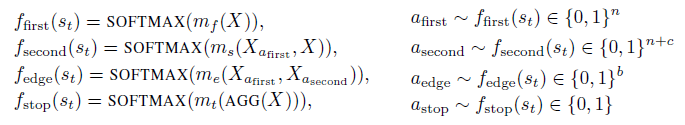

### Policy Gradient Training
Proximal Policy Optimization(PPO) 방식을 채용하였다. 간단히 말하자면, 주어진 분자 데이터셋에 대해서 무작위로 molecular graph $G$를 샘플링하고 무작위로 $s_t$ 상태의 $G$에서 subgraph $G'$을 선택한다. $s_t$ 상태에서는 원자나 결합을 $G/G'$에 더하는 액션이 취해질 수 있다. 그것을 통해 무작위로 액션을 샘플링하고 $(s_t, a_t)$를 목표로 한 분자를 만들기 위해 사용한다.